In [ ]:
!nvidia-smi

Mon Dec  6 18:39:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import Modules

In [ ]:
import torch

import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import pandas as pd

from torch.cuda import is_available
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, random_split, Dataset

%matplotlib inline

In [ ]:
device='cuda' if is_available() else 'cpu'

# Download dataset and calculate means and stds

In [ ]:
all_data=CIFAR10(root='.',train=True,transform=transforms.ToTensor(),download=True)

meanRGB=[np.mean(x.numpy(),axis=(1,2)) for x,_ in all_data]
stdRGB=[np.std(x.numpy(),axis=(1,2)) for x,_ in all_data]

meanR = np.mean([m[0] for m in meanRGB])
meanG = np.mean([m[1] for m in meanRGB])
meanB = np.mean([m[2] for m in meanRGB])

stdR = np.mean([s[0] for s in stdRGB])
stdG = np.mean([s[1] for s in stdRGB])
stdB = np.mean([s[2] for s in stdRGB])

print('Mean:',meanR, meanG, meanB)
print('Std:',stdR, stdG, stdB)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to .
Mean: 0.49139965 0.48215845 0.4465309
Std: 0.20220213 0.19931543 0.20086348


# Implement CustomSubset
To use different augmentations to train subset and validation set.

In [ ]:
class CustomSubset(Dataset):
    def __init__(self,Subset,transform=None):
        super(CustomSubset,self).__init__()
        self.Subset=Subset
        self.indices=Subset.indices
        self.transform=transform

    def __len__(self):
        return len(self.Subset)

    def __getitem__(self,idx):
        img,label=self.Subset[idx]
        if self.transform is not None:
            img=self.transform(img)
        return img,label

In [ ]:
transform={
    'train':transforms.Compose([
                                transforms.Resize((256,256)),
                                transforms.RandomResizedCrop((224,224)),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize([meanR,meanG,meanB],[stdR,stdG,stdB])
            ]),
    'test':transforms.Compose([
                               transforms.Resize((256,256)),
                               transforms.CenterCrop((224,224)),
                               transforms.RandomHorizontalFlip(),
                               transforms.ToTensor(),
                               transforms.Normalize([meanR,meanG,meanB],[stdR,stdG,stdB])
            ])
}

train_ratio=0.8
train_data_len=int(len(all_data)*0.8)
valid_data_len=len(all_data)-train_data_len

train_data,valid_data=random_split(all_data,[train_data_len,valid_data_len])

all_data.transform=None
train_data=CustomSubset(train_data,transform['train'])
valid_data=CustomSubset(valid_data,transform['test'])
test_data=CIFAR10(root='.',train=False,transform=transform['test'],download=True)

Files already downloaded and verified


In [ ]:
idx_to_class={0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}

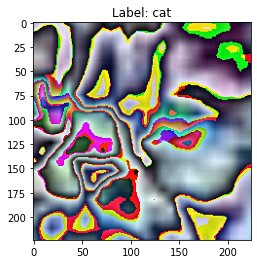

In [ ]:
img=transforms.ToPILImage()(train_data[0][0])

plt.title('Label: {}'.format(idx_to_class[train_data[0][1]]))
plt.imshow(img)

# Define configurations of VGG
Variable `cfgs` contains configurations of each VGG types.  
Each key means the name of configuration and each value contains descriptions of each layer.  
An integer(one of 64,128,256,512) means that there is a 3x3 convolutional layer and its out_channels.  
'M' means that there is MaxPool2d layer.  
  
Though PyTorch did not implement configutation 'A-LRN' and 'C' due to their unnecessity, I added those configurations.  
'L' means that there is LocalResponseNorm layer.  
'1-(some integer)' means that there is a 1x1 convolutional layer and its out_channels.  


In [ ]:
cfgs={'A':[64,'M',128,'M',256,256,'M',512,512,'M',512,512,'M'],
      'A-LRN':[64,'L','M',128,'M',256,256,'M',512,512,'M',512,512,'M'],
      'B':[64,64,'M',128,128,'M',256,256,'M',512,512,'M',512,512,'M'],
      'C':[64,64,'M',128,128,'M',256,256,'1-256','M',512,512,'1-512','M',512,512,'1-512','M'],
      'D':[64,64,'M',128,128,'M',256,256,256,'M',512,512,512,'M',512,512,512,'M'],
      'E':[64,64,'M',128,128,'M',256,256,256,256,'M',512,512,512,512,'M',512,512,512,512,'M']}

# Define a Model

In [ ]:
class VGG(nn.Module):
    def __init__(self,cfg,num_classes=1000):
        super(VGG,self).__init__()
        self.cfg=cfg
        self.net=self._build_layers()
        self.fc=nn.Sequential(
                    nn.Linear(in_features=25088,out_features=4096),
                    nn.ReLU(inplace=True),
                    nn.Dropout(p=0.5),
                    nn.Linear(in_features=4096,out_features=4096),
                    nn.ReLU(inplace=True),
                    nn.Dropout(p=0.5),
                    nn.Linear(in_features=4096,out_features=num_classes)
                )
        # self._init_weights() As same issue at implementation of AlexNet, initializing network's weight caused poor performance
        
        
    def forward(self,x):
        x=self.net(x)
        x=torch.flatten(x,1)
        x=self.fc(x)
        return x
        
    def _build_layers(self):
        net=[]
        in_channels=3
        for layer in self.cfg:
            if layer=='M': # MaxPool2d
                net.append(nn.MaxPool2d(kernel_size=2,stride=2))
            elif layer=='L': # LocalResponseNorm
                net.append(nn.LocalResponseNorm(size=5,alpha=0.0001,beta=0.75,k=2.0))
            else:
                if type(layer)=='str': # 1x1 Conv
                    net.append(nn.Conv2d(in_channels=in_channels,out_channels=int(layer[2:]),kernel_size=1,stride=1,padding=1))
                    in_channels=int(layer[2:])
                else: # 3x3 Conv
                    net.append(nn.Conv2d(in_channels=in_channels,out_channels=layer,kernel_size=3,stride=1,padding=1))
                    in_channels=layer
                net.append(nn.ReLU())
        return nn.Sequential(*net)


    def _init_weights(self):
        for layer in self.modules():
            if isinstance(layer,nn.Conv2d) or isinstance(layer,nn.Linear):
                nn.init.normal_(layer.weight,mean=0.0,std=0.1)
                nn.init.constant_(layer.bias,0)

# Prepare trianing step

In [ ]:
batch_size=128

train_loader=DataLoader(train_data,batch_size=batch_size,shuffle=True)
valid_loader=DataLoader(valid_data,batch_size=batch_size,shuffle=False)
test_loader=DataLoader(test_data,batch_size=batch_size,shuffle=False)

In [ ]:
model=VGG(cfg=cfgs['A'],num_classes=10)
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.01,momentum=0.9,weight_decay=0.0005)

model=model.to(device)
criterion=criterion.to(device)

In [ ]:
print(model)

VGG(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU()
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


# Train and validation
The training step procedded about 30 epochs conducted 3 times, 10 epochs each due to colab GPU limitations.  
So the graphs below in fact start at 21 epoch.

In [ ]:
def train(model,criterion,optimizer,train_loader,valid_loader,num_epochs=10,print_every=1,early_stop=None,model_path='vgg.pth'):
    train_logs={'Loss':[],'Accuracy':[]}
    valid_logs={'Loss':[],'Accuracy':[]}
    patience=0
    best_acc=-np.inf
    for epoch in range(num_epochs):
        train_loss=0
        valid_loss=0
        train_acc=0
        valid_acc=0
        # training step
        model.train()
        for data,target in train_loader:
            optimizer.zero_grad()
            data,target=data.to(device),target.to(device)
            pred=model(data)
            loss=criterion(pred,target)
            loss.backward()
            optimizer.step()
            train_loss+=loss.item()*data.size(0)
            train_acc+=torch.sum(pred.argmax(1)==target).item()
        train_loss/=len(train_data)
        train_acc/=len(train_data)
        train_logs['Loss'].append(train_loss)
        train_logs['Accuracy'].append(train_acc)
        if (epoch+1)%print_every==0:
            print('Training   Epoch {} - Loss : {:.8f} Accuracy : {:.4f}%'.format(epoch,train_loss,train_acc*100))
        # validation step
        with torch.no_grad():
            model.eval()
            for data,target in valid_loader:
                data,target=data.to(device),target.to(device)
                pred=model(data)
                loss=criterion(pred,target)
                valid_loss+=loss.item()*data.size(0)
                valid_acc+=torch.sum(pred.argmax(1)==target).item()
            valid_loss/=len(valid_data)
            valid_acc/=len(valid_data)
            valid_logs['Loss'].append(valid_loss)
            valid_logs['Accuracy'].append(valid_acc)
            if (epoch+1)%print_every==0:
                print('Validation Epoch {} - Loss : {:.8f} Accuracy : {:.4f}%'.format(epoch,valid_loss,valid_acc*100))
            if valid_acc>best_acc:
                best_acc=valid_acc
                torch.save(model.state_dict(),model_path)
                if early_stop is not None:
                    patience=0
            elif early_stop is not None:
                patience+=1
                if patience>=early_stop:
                    print('Training finished by early stopping')
                    return train_logs,valid_logs
    return train_logs,valid_logs

In [ ]:
train_logs,valid_logs = train(model=model,
                              criterion=criterion,
                              optimizer=optimizer,
                              train_loader=train_loader,
                              valid_loader=valid_loader,
                              num_epochs=10,
                              print_every=1,
                              early_stop=None,
                              model_path='vgg_a.pth')

Training   Epoch 0 - Loss : 1.04288373 Accuracy : 63.4525%
Validation Epoch 0 - Loss : 0.66070115 Accuracy : 77.0000%
Training   Epoch 1 - Loss : 1.02067237 Accuracy : 64.1750%
Validation Epoch 1 - Loss : 0.65584995 Accuracy : 77.9400%
Training   Epoch 2 - Loss : 0.97258581 Accuracy : 65.7950%
Validation Epoch 2 - Loss : 0.65532604 Accuracy : 77.5200%
Training   Epoch 3 - Loss : 0.95117931 Accuracy : 66.8550%
Validation Epoch 3 - Loss : 0.63300046 Accuracy : 78.3700%
Training   Epoch 4 - Loss : 0.93049398 Accuracy : 67.1750%
Validation Epoch 4 - Loss : 0.62734334 Accuracy : 78.0300%
Training   Epoch 5 - Loss : 0.90955932 Accuracy : 68.1300%
Validation Epoch 5 - Loss : 0.60611022 Accuracy : 79.6600%
Training   Epoch 6 - Loss : 0.88789094 Accuracy : 68.8850%
Validation Epoch 6 - Loss : 0.54923095 Accuracy : 81.2100%
Training   Epoch 7 - Loss : 0.85981791 Accuracy : 69.7750%
Validation Epoch 7 - Loss : 0.54768544 Accuracy : 81.1600%
Training   Epoch 8 - Loss : 0.85783925 Accuracy : 70.000

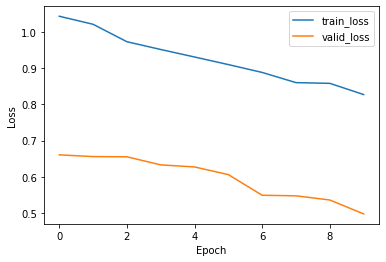

In [ ]:
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot([i for i in range(len(train_logs['Loss']))],train_logs['Loss'],label='train_loss')
plt.plot([i for i in range(len(valid_logs['Loss']))],valid_logs['Loss'],label='valid_loss')
plt.legend()
plt.show()

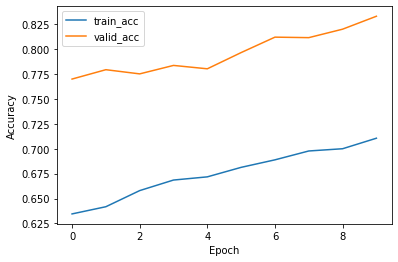

In [ ]:
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot([i for i in range(len(train_logs['Accuracy']))],train_logs['Accuracy'],label='train_acc')
plt.plot([i for i in range(len(valid_logs['Accuracy']))],valid_logs['Accuracy'],label='valid_acc')
plt.legend()
plt.show()

# Test
The test was conducted by loading a model trained up to 30 epochs.

In [ ]:
model.load_state_dict(torch.load('vgg_a.pth'))
model=model.to(device)

In [ ]:
def test(model,criterion,test_loader):
    test_loss=0
    test_acc=0
    result_table=pd.DataFrame(columns=['Prediction','Target'])
    with torch.no_grad():
        model.eval()
        for data,target in test_loader:
            data,target=data.to(device),target.to(device)
            pred=model(data)
            loss=criterion(pred,target)
            test_loss+=loss.item()*data.size(0)
            test_acc+=torch.sum(pred.argmax(1)==target).item()
            for p,t in zip(pred.argmax(1),target):
                result_table=result_table.append({'Prediction':p.item(),'Target':t.item()},ignore_index=True)
        test_loss/=len(test_data)
        test_acc/=len(test_data)
    return test_loss,test_acc,result_table

In [ ]:
test_loss,test_acc,result_table=test(model=model,
                                     criterion=criterion,
                                     test_loader=test_loader)

In [ ]:
print('Test Loss : {:.8f} Test Accuracy : {:.4f}%'.format(test_loss,test_acc*100))

Test Loss : 0.51172855 Test Accuracy : 83.3200%


In [ ]:
result_table

,Prediction,Target
0,3,3
1,8,8
2,8,8
3,8,0
4,4,6
...,...,...
9995,8,8
9996,3,3
9997,5,5
9998,1,1


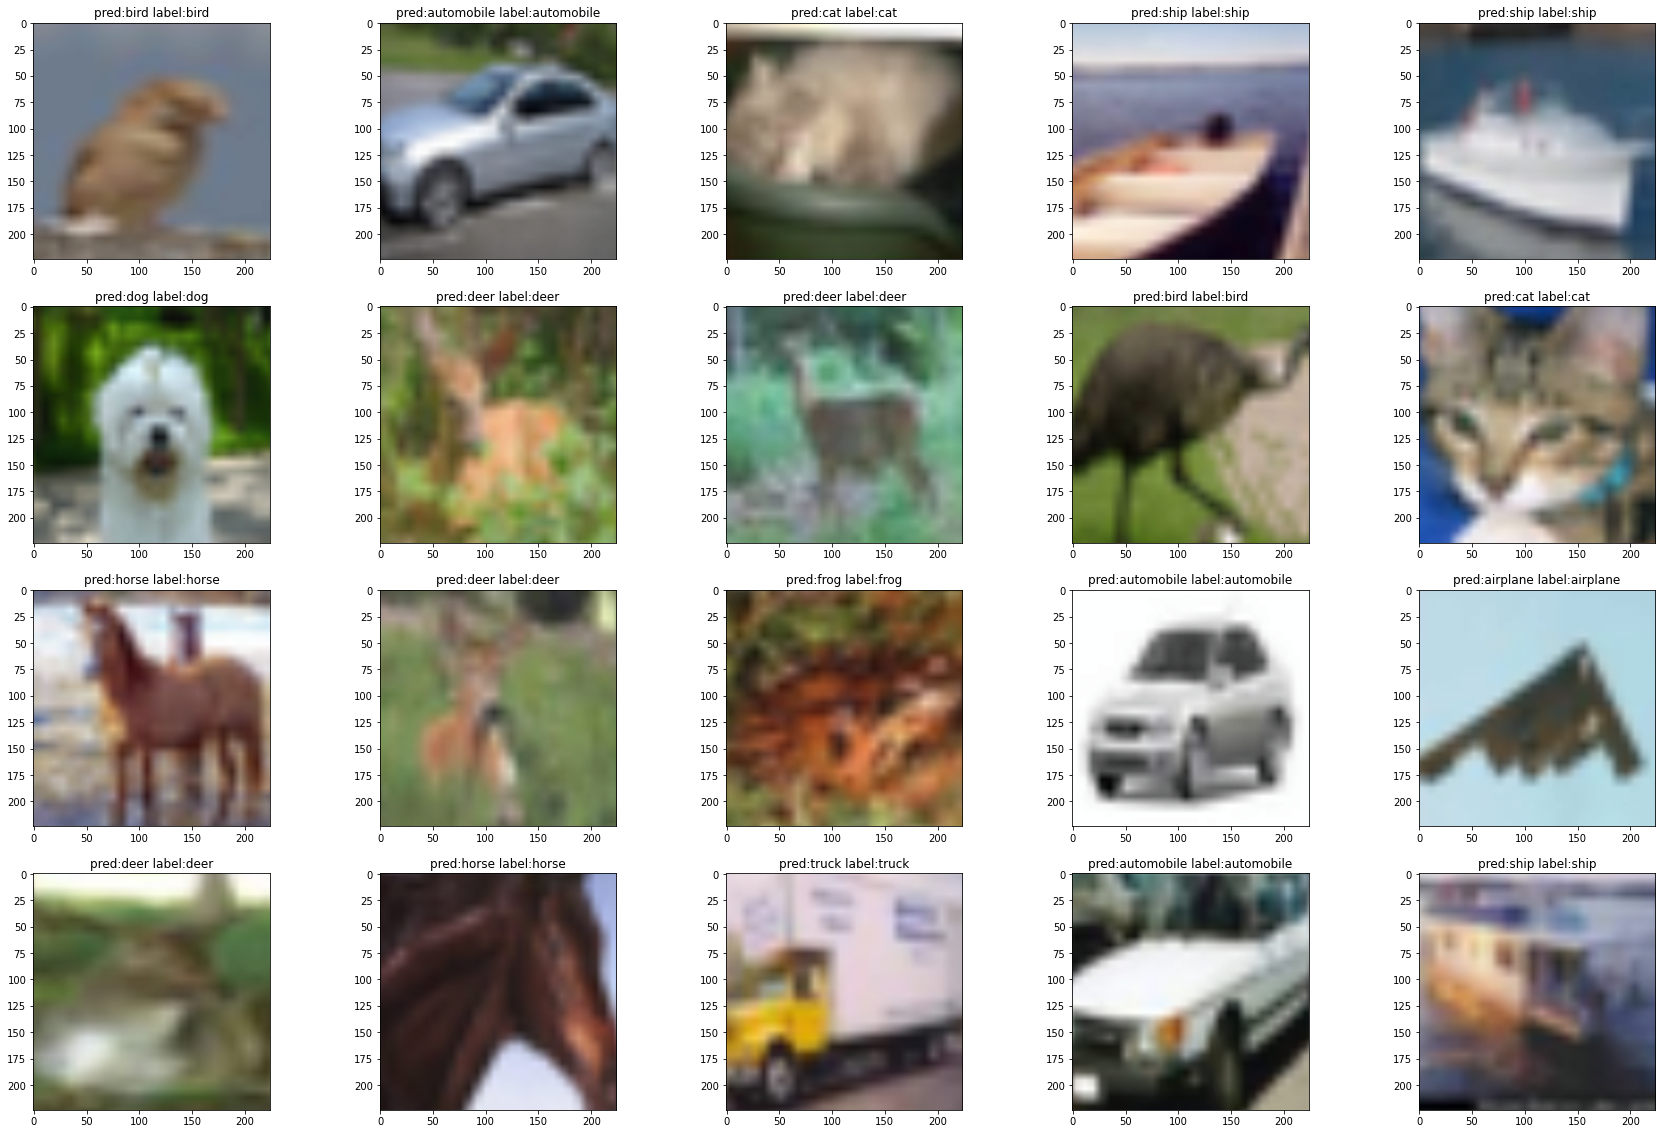

In [ ]:
unNormalizeAndToImage=transforms.Compose([transforms.Normalize([-meanR/stdR,-meanG/stdG,-meanB/stdB],[1.0/stdR,1.0/stdG,1.0/stdB]),
                                          transforms.ToPILImage()])
fig=plt.figure(figsize=(30,20))
cols=5
rows=4
sample_index=np.random.randint(0,len(test_data),size=(cols*rows))

for i in range(1,cols*rows+1):
    img=unNormalizeAndToImage(test_data[sample_index[i-1]][0])
    pred=model(test_data[sample_index[i-1]][0].unsqueeze(0).to(device))
    fig.add_subplot(rows,cols,i)
    plt.title('pred:{} label:{}'.format(idx_to_class[pred.argmax().cpu().item()],idx_to_class[test_data[sample_index[i-1]][1]]))
    plt.imshow(img,cmap='gray')
plt.show()